In [10]:
# import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import plotly.express as px  # for interative visualizations

In [12]:
# read the data
df = pd.read_csv('../data/us_counties.csv')

# filter for Texas counties, copying rather than slicing
texas_counties = df[df['State'] == 'TX'].copy()

print(texas_counties)

       fips State        Area_name  rural_urban_code  pop2018  unemp2018  \
2507  48001    TX  Anderson County                 7    58057        3.1   
2508  48003    TX   Andrews County                 6    18128        2.4   
2509  48005    TX  Angelina County                 5    87092        4.4   
2510  48007    TX   Aransas County                 2    23792        5.7   
2511  48009    TX    Archer County                 3     8786        3.1   
...     ...   ...              ...               ...      ...        ...   
2756  48499    TX      Wood County                 6    45129        4.2   
2757  48501    TX    Yoakum County                 7     8591        2.8   
2758  48503    TX     Young County                 7    18045        3.2   
2759  48505    TX    Zapata County                 6    14190        5.6   
2760  48507    TX    Zavala County                 7    11983        9.5   

      median_income2018  percent_college2018  
2507              45969                 

In [13]:
# perform a log transformation on 'pop2018'
texas_counties['logpop2018'] = np.log(texas_counties['pop2018'])

# define the variables to be standardized
vars_to_standardize = ['rural_urban_code', 'logpop2018', 'unemp2018', 'median_income2018', 'percent_college2018']

# create a scaler object
scaler = StandardScaler()

# fit and transform the data
texas_counties[vars_to_standardize] = scaler.fit_transform(texas_counties[vars_to_standardize])

In [14]:
# specify the hyperparameters. For example, we can start with a perplexity of 30 
# and a learning rate (also called epsilon) of 200. These are common starting values for tSNE.
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=1000, learning_rate=200)

# run t-SNE on the standardized data
tsne_results = tsne.fit_transform(texas_counties[vars_to_standardize])


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 254 samples in 0.000s...
[t-SNE] Computed neighbors for 254 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 254 / 254
[t-SNE] Mean sigma: 0.701723
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.383518
[t-SNE] KL divergence after 1000 iterations: 0.409343


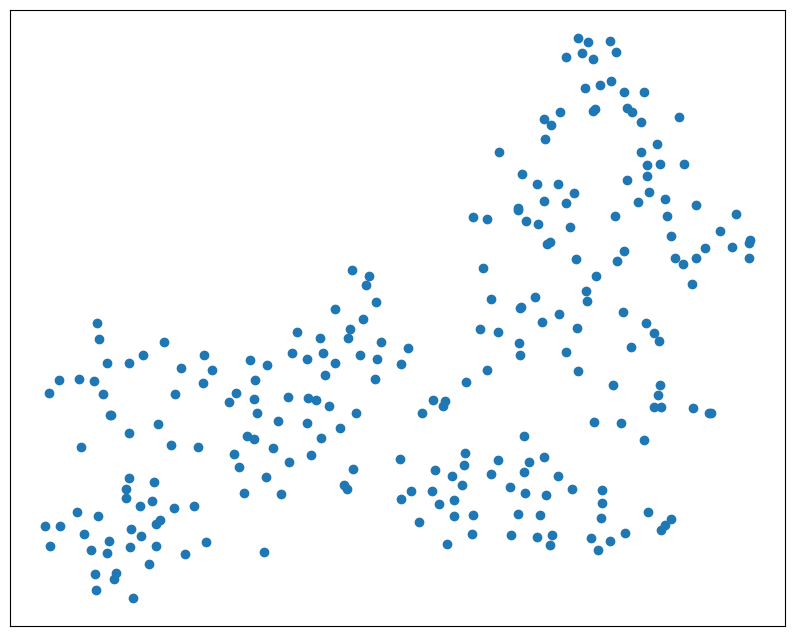

In [15]:
# create a scatter plot
plt.figure(figsize=(10,8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.show()

In [16]:
# Not super helpful because we don't know what the points are

# convert the t-SNE results to a DataFrame
tsne_df = pd.DataFrame(data = tsne_results, columns = ['Dim1', 'Dim2'])

# add the county names to this DataFrame
tsne_df['County'] = texas_counties['Area_name'].values

# create an interactive plot
fig = px.scatter(tsne_df, x='Dim1', y='Dim2', hover_data=['County'])
fig.show()


In [17]:
# define 'Smallest', 'Largest' or 'Other' category
texas_counties['pop_category'] = 'Other'
texas_counties.loc[texas_counties['pop2018'].nsmallest(10).index, 'pop_category'] = 'Smallest'
texas_counties.loc[texas_counties['pop2018'].nlargest(10).index, 'pop_category'] = 'Largest'

# add the categories to this DataFrame
tsne_df['Category'] = texas_counties['pop_category'].values

# create an interactive plot
fig = px.scatter(tsne_df, x='Dim1', y='Dim2', color='Category', hover_data=['County'])
fig.show()

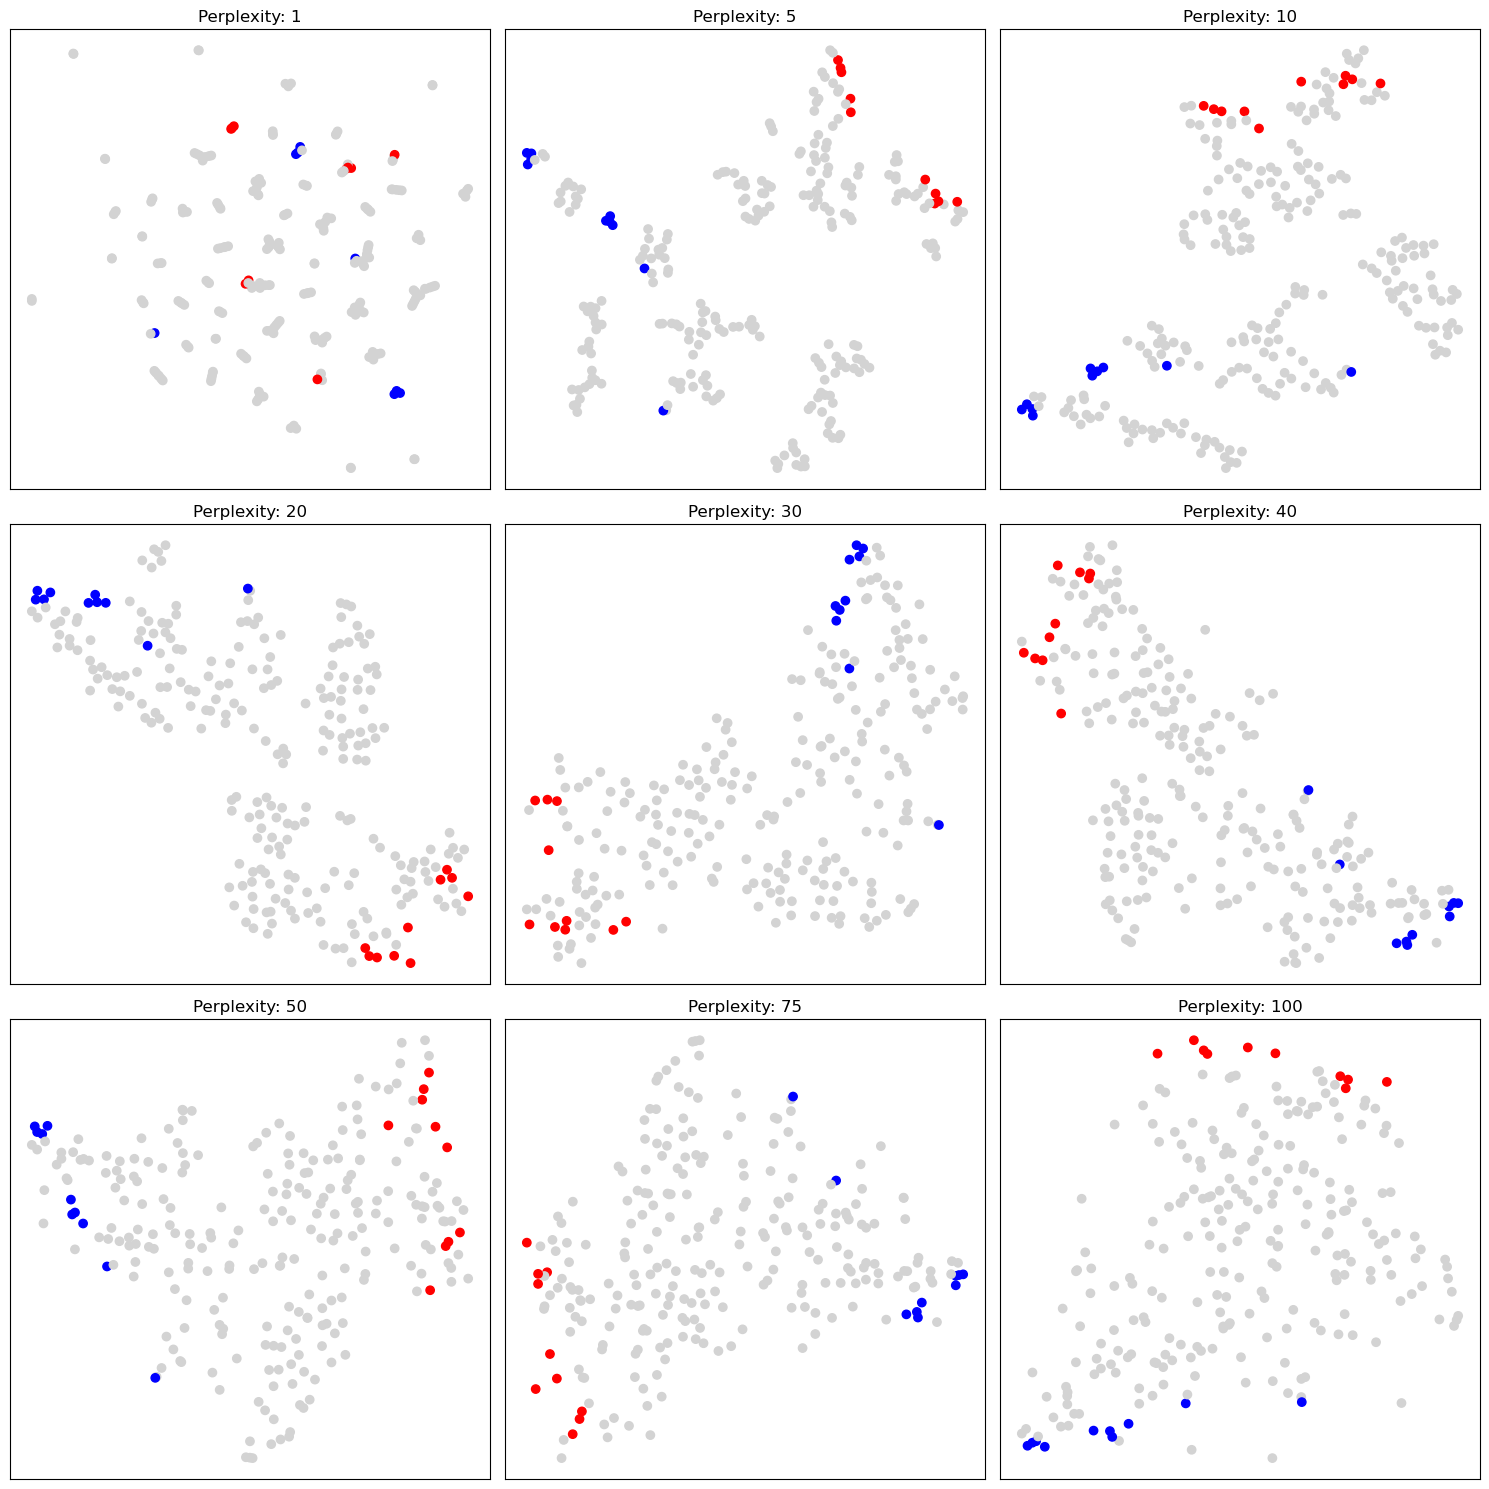

In [18]:
# Let's see what happens as we vary the perplexity parameter

# define perplexity values to use
perplexities = [1, 5, 10, 20, 30, 40, 50, 75, 100]

# create a 3x3 grid of subplots
fig, axs = plt.subplots(3, 3, figsize=(15,15))

# reshape axs to 1D array
axs = axs.flatten()

for i, perplexity in enumerate(perplexities):
    # run t-SNE with the specified perplexity
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=1000, learning_rate=200)
    tsne_results = tsne.fit_transform(texas_counties[vars_to_standardize])
    
    # convert the t-SNE results to a pandas DataFrame
    tsne_df = pd.DataFrame(data = tsne_results, columns = ['Dim1', 'Dim2'])

    # add the categories to this DataFrame
    tsne_df['Category'] = texas_counties['pop_category'].values

    # create a scatter plot in the corresponding subplot
    scatter = axs[i].scatter(tsne_df['Dim1'], tsne_df['Dim2'], c=tsne_df['Category'].map({'Smallest':'red', 'Largest':'blue', 'Other':'lightgrey'}))
    axs[i].set_title(f'Perplexity: {perplexity}')
    axs[i].set_xticks([])
    axs[i].set_yticks([])

# show the plot
plt.tight_layout()
plt.show()

In [19]:
# Let's try a bigger data set: ~18K posts on old Usenet newsgroups 
# (like the pre-web version of something more modern like Reddit or StackOverflow)

# Import data
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

# Load 20 Newsgroups dataset
newsgroups = fetch_20newsgroups(subset='all')


In [20]:
# Convert the text to TF-IDF weighted word vectors
# our vocabulary considers the top 1000 terms ordered by term frequency across the corpus
# we're ignoring non-content words like "the", "a", "of" etc
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
vectors = vectorizer.fit_transform(newsgroups.data)

# 1000 features
vectors.shape

(18846, 1000)

In [21]:
# Perform PCA to reduce dimensionality before t-SNE
pca = PCA(n_components=50)
vectors_pca = pca.fit_transform(vectors.toarray())  # toarray to create a dense matrix from a sparse one
vectors_pca.shape

(18846, 50)

In [22]:
# Create labels for visualization
labels = [newsgroups.target_names[i] for i in newsgroups.target]

# Use t-SNE to reduce dimensionality to D=2 for visualization
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=1000)
vectors_tsne = tsne.fit_transform(vectors_pca)

# Create a DataFrame for visualization
df_tsne = pd.DataFrame(vectors_tsne, columns=["Component 1", "Component 2"])
df_tsne['Label'] = labels

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 18846 samples in 0.002s...
[t-SNE] Computed neighbors for 18846 samples in 0.213s...
[t-SNE] Computed conditional probabilities for sample 1000 / 18846
[t-SNE] Computed conditional probabilities for sample 2000 / 18846
[t-SNE] Computed conditional probabilities for sample 3000 / 18846
[t-SNE] Computed conditional probabilities for sample 4000 / 18846
[t-SNE] Computed conditional probabilities for sample 5000 / 18846
[t-SNE] Computed conditional probabilities for sample 6000 / 18846
[t-SNE] Computed conditional probabilities for sample 7000 / 18846
[t-SNE] Computed conditional probabilities for sample 8000 / 18846
[t-SNE] Computed conditional probabilities for sample 9000 / 18846
[t-SNE] Computed conditional probabilities for sample 10000 / 18846
[t-SNE] Computed conditional probabilities for sample 11000 / 18846
[t-SNE] Computed conditional probabilities for sample 12000 / 18846
[t-SNE] Computed conditional probabilities for sam

In [23]:
# just a helper functon for plotting
def plot_tsne(color=df_tsne.columns):
    fig = px.scatter(df_tsne, x="Component 1", y="Component 2", color=color, title="t-SNE visualization of 20 Newsgroups dataset")
    fig.update_layout(autosize=False, width=1000, height=1000)
    fig.show()

In [24]:
# obviously a big muddle in the middle but some clear clustering structure!  
plot_tsne("Label")